# Projet réseaux de neurones - OCR

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image, ImageFont, ImageDraw
from PIL import Image
import cv2
import pytesseract
from pytesseract import Output
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

### 1. Chargement des données

In [3]:
# Chemin vers le fichier texte contenant les labels et les chemins vers les images
file_path = "data/12.txt"
with open(file_path, "r") as file:
    lines = file.readlines()

# Extraire les labels et les chemins vers les images
tuples = [(l.split('`')[0], l.split('`')[1].strip()) for l in lines]

# Vérification de l'existence des fichiers
result = [(f"data/{item[0]}", item[1], os.path.exists(f"data/{item[0]}")) for item in tuples]


# Filtrer les données existantes
data = []
for file, label, exists in result:
    if exists:
        data.append((file, label))

In [4]:
dataset = data[0:20000]
len(dataset)

20000

### 2. Découpage du mot en caractères

- **Fonction pour segmenter une image de mot en images des caractères**

In [5]:
def split_text_into_characters_tesseract(image_path):
    """
    Découpe une image de mot en images de caractères individuels en utilisant PyTesseract.
    
    Parameters:
        image_path (str): Chemin vers l'image du mot.
    
    Returns:
        list: Liste des images des caractères en format PIL.
    """
    # Charger l'image
    image = cv2.imread(image_path)

    # Convertir en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Binarisation des pixels (0 si prche de noir ; 255 si proche de blanc)
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Utiliser PyTesseract pour détecter les caractères
    boxes = pytesseract.image_to_boxes(binary_image, config="--psm 7")

    # Initialiser la liste des images des caractères
    characters = []

    # Vérifier si des boxes ont été détectées
    if boxes:

        # Parcourir les boxes et extraire les images des caractères
        for box in boxes.splitlines():

            # Spliter les données de la box
            box_data = box.split()

            # Vérifier que la box est bien au format attendu (char, x1, y1, x2, y2, page)
            if len(box_data) == 6:

                # Extraire les caractères et les coordonnées de la box
                char, x, y, w, h, _ = box_data

                # Convertir les coordonnées en entiers
                x, y, w, h = map(int, [x, y, w, h])

                # Ajustement des coordonnées entre pytesseract et cv2 (origine différente)           
                y = image.shape[0] - y
                h = image.shape[0] - h

                # Découper l'image du caractère
                char_image = binary_image[h:y, x:w]

                # Convertir en format PIL
                char_pil = Image.fromarray(char_image)
                characters.append(char_pil)

    return characters

- **Application de la fonction de découpage d'un mot en caractères au jeu de données**

In [6]:
def process_dataset_tesseract(dataset):
    """
    Traite un jeu de données pour découper les images de mots en images de caractères avec PyTesseract.
    
    Parameters:
        dataset (list): Liste de tuples (chemin_image, mot).
    
    Returns:
        list: Liste de tuples ([images des caractères], [caractères]).
    """

    # Initialiser la liste des données traitées
    processed_data = []

    # Initialiser les compteurs d'erreurs de correspondance et de découpage de caractères
    wrong_corr = 0
    caracteres_colles = 0
    caracteres_coupes = 0

    # Parcourir les données du jeu de données
    for image_path, word in dataset:

        # Découper l'image en caractères à l'aide de la fonction définie précédemment
        character_images = split_text_into_characters_tesseract(image_path)

        # Si le nombre de caractères détectés correspond au nombre de caractères du mot
        if len(character_images) == len(word):

            # Associer les images des caractères au mot correspondant et ajouter le tuple à processed_data
            processed_data.append((character_images, list(word)))
        
        # Si le nombre de caractères détectés ne correspond pas au mot
        else:

            # Incrémenter le compteur d'erreurs de correspondance
            wrong_corr += 1
            if len(character_images) < len(word):
                caracteres_colles += 1
            if len(character_images) > len(word):
                caracteres_coupes += 1
    
    # Afficher les résultats de correspondances
    print(f"Bonnes correspondances = {len(processed_data)}")
    print(f"Mauvaises correspondances = {wrong_corr}")
    print(f"Caractères collés = {caracteres_colles}")
    print(f"Caractères coupés = {caracteres_coupes}")

    return processed_data

processed_dataset = process_dataset_tesseract(dataset)


Bonnes correspondances = 14606
Mauvaises correspondances = 5394
Caractères collés = 3538
Caractères coupés = 1856


### 3. Reconnaissance des caractères du mot

- **Préparer les données**

In [7]:
def prepare_data(processed_dataset, image_size=(28, 28)):
    """
    Transforme les données traitées en un format adapté pour entraîner un modèle neuronal.
    
    Parameters:
        processed_dataset (list): Liste de tuples ([images des caractères], [caractères]).
        image_size (tuple): Dimensions des images après redimensionnement (par défaut 28x28).
    
    Returns:
        tuple: (X, y) où X est un tableau numpy des images et y les étiquettes correspondantes.
    """

    # Initialiser les listes pour les images et les étiquettes
    X = []
    y = []

    # Parcourir tous les tuples du jeu de données
    for character_images, word_characters in processed_dataset:

        # Parcourir les images et les caractères de chaque mot
        for img, char in zip(character_images, word_characters):

            # Redimensionner l'image à la taille spécifiée
            img_resized = img.resize(image_size)

            # Convertir en tableau numpy
            img_array = np.array(img_resized)

            # Normaliser les valeurs des pixels (0 pour 0 et 1 pour 225)
            img_normalized = img_array / 255.0

            # Ajouter l'image à la liste des images et l'étiquette à la liste des étiquettes
            X.append(img_normalized)
            y.append(char)

    # Convertir la liste d'images en tableau numpy
    X = np.array(X)

    # Ajouter automatiquement la taille du tableau en 1er argument et la dimensions des canaux (dans notre cas en niveaux de gris donc 1) en dernier argument
    X = X.reshape(-1, image_size[0], image_size[1], 1)

    # Convertir la liste des étiquettes en tableau numpy
    y = np.array(y)

    return X, y

# Préparer les données
image_size = (28, 28)
X, y = prepare_data(processed_dataset, image_size=image_size)

In [ ]:
y

In [ ]:
# Sauvegarde au format .npy
np.save('classes.npy', y)

In [8]:
# Encoder les étiquettes
label_encoder = LabelEncoder()

# Convertir les caractères en indices numériques
y_encoded = label_encoder.fit_transform(y)

# Convertir les étiquettes en vecteurs one-hot
y_one_hot = to_categorical(y_encoded)

- **Créer le modèle**

In [9]:
def create_character_recognition_model(input_shape, nb_classes):
    """
    Crée un modèle CNN pour la reconnaissance de caractères.
    
    Parameters:
        input_shape (tuple): Dimensions de l'image d'entrée (hauteur, largeur, canaux).
        nb_classes (int): Nombre total de classes (caractères uniques).
    
    Returns:
        model: Modèle de reconnaissance de caractères.
    """

    # Créer une séquence de couches pour le modèle
    model = Sequential([

        # Première couche de convolution (couche d'entrée)
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),

        # Réduire les dimensions de l'image
        MaxPooling2D((2, 2)),

        # Deuxième couche de convolution
        Conv2D(64, (3, 3), activation='relu'),

        # Réduire les dimensions de l'image
        MaxPooling2D((2, 2)),

        # Transformer les sorties 2D des couches de convolution et de pooling en un vecteur à 1 dimension
        Flatten(),

        # Couche dense connectée à toutes les sorties précédentes
        Dense(128, activation='relu'),

        # Couche de dropout pour réduire le sur-apprentissage
        Dropout(0.5),

        # Couche de sortie
        Dense(nb_classes, activation='softmax'),
    ])

    return model

# Définir la taille des images d'entrée avec le canal de niveaux de gris
input_shape = (image_size[0], image_size[1], 1)

# Nombre total de caractères uniques dans le jeu de données
num_classes = len(label_encoder.classes_)

# Créer le modèle de reconnaissance de caractères
model = create_character_recognition_model(input_shape, num_classes)

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/amandine/newenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-21 09:54:56.317242: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


- **Séparation train/test**

In [10]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

- **Entraînement du modèle**

In [11]:
# Entraîner le modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20


2025-01-21 09:55:03.514171: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 335486144 exceeds 10% of free system memory.


3344/3344 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.4693 - loss: 2.1215 - val_accuracy: 0.6686 - val_loss: 1.2789
Epoch 2/20
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.6352 - loss: 1.4237 - val_accuracy: 0.6928 - val_loss: 1.1788
Epoch 3/20
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.6630 - loss: 1.3008 - val_accuracy: 0.7099 - val_loss: 1.1149
Epoch 4/20
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.6803 - loss: 1.2211 - val_accuracy: 0.7202 - val_loss: 1.0733
Epoch 5/20
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.6923 - loss: 1.1713 - val_accuracy: 0.7275 - val_loss: 1.0563
Epoch 6/20
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.7034 - loss: 1.1240 - val_accuracy: 0.7278 - val_loss: 1.0442
Epoch 7/20
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.7089 - loss: 1.0891 - val_accuracy: 0.7265 - val_loss: 1.0486
Epoch 8/20
3344/3344 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - accuracy: 0.7127 - loss: 1.07

- **Prédiction d'un mot à partir d'une image**

In [14]:
def predict_word(image_path, model, label_encoder, image_size=(28, 28)):
    """
    Prédit un mot à partir d'une image de mot.
    
    Parameters:
        image_path (str): Chemin vers l'image du mot.
        model: Modèle entraîné pour la reconnaissance de caractères.
        label_encoder: Encodeur pour convertir les prédictions en caractères.
        image_size (tuple): Dimensions des images pour le modèle.
    
    Returns:
        str: Mot prédit.
    """
    # Découper l'image en caractères
    character_images = split_text_into_characters_tesseract(image_path)

    predicted_word = ""
    for img in character_images:
        # Prétraiter l'image
        img_resized = img.resize(image_size)
        img_array = np.array(img_resized) / 255.0
        img_array = img_array.reshape(1, image_size[0], image_size[1], 1)

        # Prédire le caractère
        prediction = model.predict(img_array)
        char = label_encoder.inverse_transform([np.argmax(prediction)])[0]

        predicted_word += char

    return predicted_word

# Prédire un mot à partir d'une image (exemple : kujuj.png)
predicted_word = predict_word("data/kujuj.png", model, label_encoder)
print(f"Mot prédit : {predicted_word}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Mot prédit : Kujuj


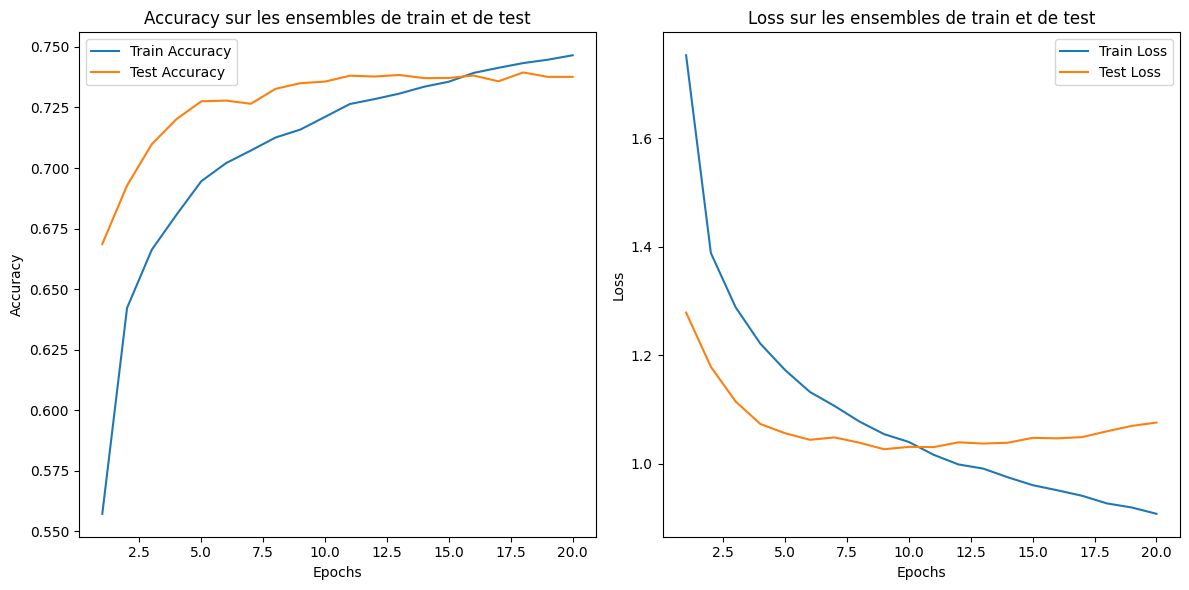

In [15]:
def plot_training_history(history):
    """
    Affiche l'accuracy et la perte du modèle au cours de l'entraînement.
    
    Parameters:
        history: Objet History retourné par model.fit().
    """

    # Extraire les données de l'entraînement
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    # Afficher l'accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Test Accuracy')
    plt.title('Accuracy sur les ensembles de train et de test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Afficher la loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Test Loss')
    plt.title('Loss sur les ensembles de train et de test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Afficher les courbes
plot_training_history(history)

In [16]:
model.save('OCR_20000_words.h5')

-------------------------------------------

In [17]:
# Charger le modèle sauvegardé
model = load_model('OCR_20000_words.h5')

In [18]:
# Évaluer le modèle sur les données de test
val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

836/836 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7412 - loss: 1.0929
Validation Loss: 1.0759960412979126
Validation Accuracy: 0.737633228302002
